## Variação de parâmetros

Carregando experimental: ./_experimental/XANES_Pt_MoS2(160))_Exp.txt
Experimental: 415 pontos, Energia [11526.0, 11608.8] eV


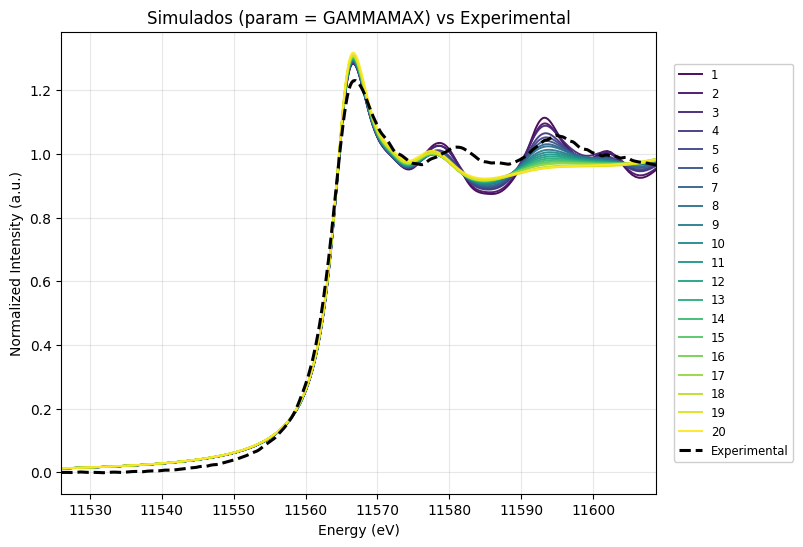

Salvo: ./param_plots/GAMMAMAX_all_curves.png


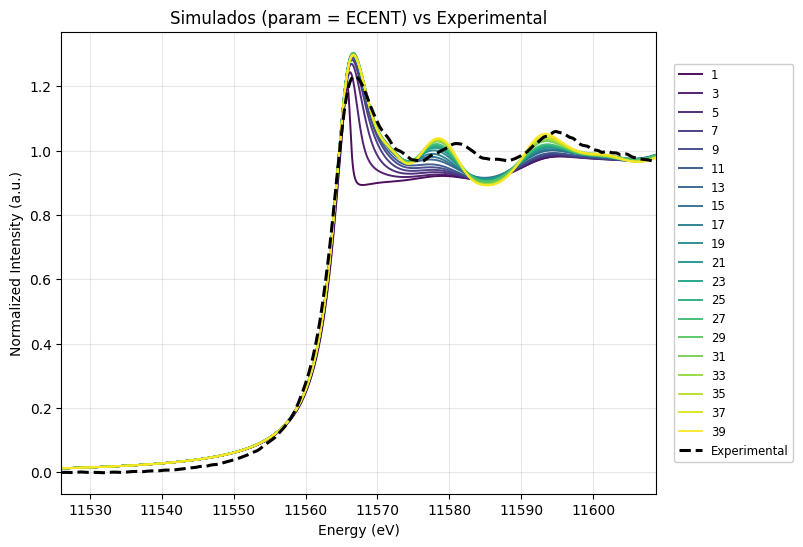

Salvo: ./param_plots/ECENT_all_curves.png


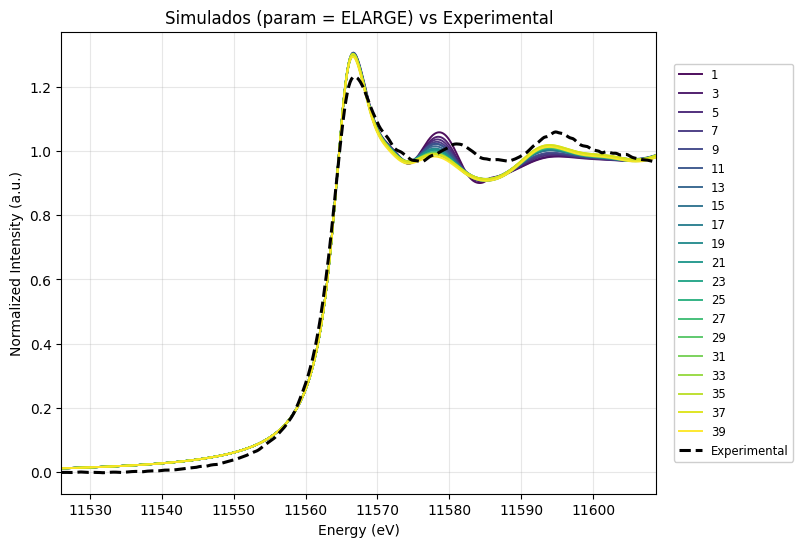

Salvo: ./param_plots/ELARGE_all_curves.png
Melhores curvas selecionadas (uma por pasta, top 3):
     folder                                          file  sim_number  \
0    ELARGE  fdmnes-restart.out_Gm10.0_20.0_35.0_conv.txt        35.0   
1     ECENT  fdmnes-restart.out_Gm10.0_29.0_20.0_conv.txt        29.0   
2  GAMMAMAX   fdmnes-restart.out_Gm8.0_20.0_20.0_conv.txt         8.0   

   best_shift_eV      rmse  
0           1.46  0.029886  
1           1.46  0.030019  
2           1.45  0.030647  


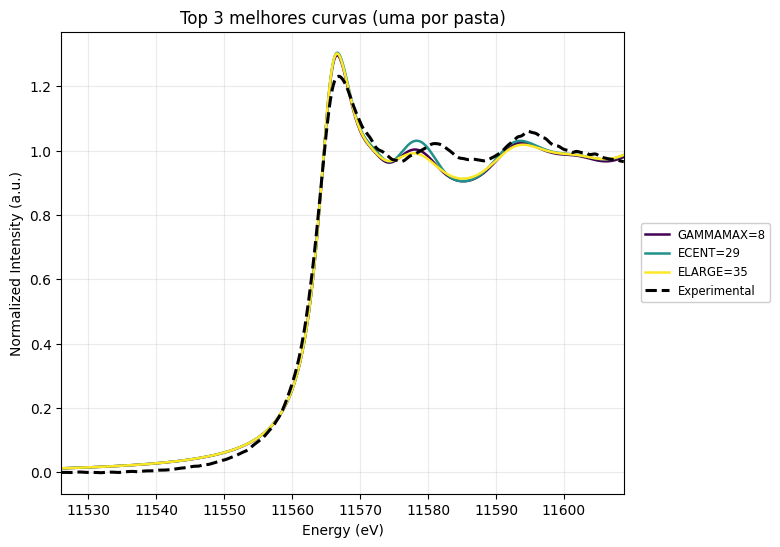

Salvo: ./param_plots/top_3_curves.png
Resumo completo salvo em: ./all_convs_summary.csv


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# -------- CONFIG --------
PARENT_DIR = '.'  # diretório onde estão as subpastas
EXP_FILE = './_experimental/XANES_Pt_MoS2(160))_Exp.txt'  # caminho para experimental
PATTERN = '*_conv.txt'            # padrão dentro de cada subpasta
OPTIMIZE_SHIFT = True
SHIFT_SEARCH = np.linspace(-2.0, 2.0, 401)
SAVE_SUMMARY = True
SUMMARY_CSV = 'all_convs_summary.csv'
OUT_PLOT_DIR = './param_plots/'
OUT_SUMMARY_DIR = './'
PLOT_MARKERS = False   # <-- DESLIGUEI os marcadores (linhas verticais e pontos)
MARKER_ALPHA = 0.7
os.makedirs(OUT_PLOT_DIR, exist_ok=True)

# ---- INPUT ----
PARAM_FOLDERS = ["GAMMAMAX", "ECENT", "ELARGE"]
# ----------------------------------------

# ----------- Funções de normalização XANES -----------

def find_E0(energies, absorption):
    if len(energies) < 3:
        return energies[0], absorption[0]
    dydx = np.diff(absorption) / np.diff(energies)
    x_new = energies[:-1]
    dydx2 = np.diff(dydx) / np.diff(x_new)
    x_new2 = x_new[:-1]

    range_search_E0_end = int(len(energies) / 2)
    deriv_max = -np.inf
    point_max = 0

    for point in range(range_search_E0_end - 1):
        if point < len(dydx2) and dydx[point] > deriv_max and dydx2[point] > 0:
            deriv_max = dydx[point]
            point_max = point

    idx = min(point_max, len(energies) - 1)
    return energies[idx], absorption[idx]

def fit_pre_edge(energies, absorption, start_index, end_index):
    start_index = max(0, int(start_index))
    end_index = min(len(energies), int(end_index))
    if end_index <= start_index + 1:
        intercept = np.mean(absorption[start_index:end_index]) if end_index > start_index else absorption[0]
        slope = 0.0
        return intercept + slope * energies
    background_x = energies[start_index:end_index]
    background_y = absorption[start_index:end_index]
    resultado_fit = linregress(background_x, background_y)
    return resultado_fit.intercept + resultado_fit.slope * energies

def XANES_normalization(energies, absorption):
    energies = np.asarray(energies, dtype=float)
    absorption = np.asarray(absorption, dtype=float)
    if energies.size != absorption.size:
        raise ValueError("energies e absorption devem ter o mesmo tamanho")

    E0x, E0y = find_E0(energies, absorption)
    E0x_index = int(np.argmin(np.abs(energies - E0x)))

    start_pre_edge_x_index = max(0, E0x_index // 15)
    end_pre_edge_x_index   = max(1, E0x_index // 4)

    linear_fit_pre_edge = fit_pre_edge(energies, absorption,
                                       start_pre_edge_x_index,
                                       end_pre_edge_x_index)
    if E0y == 0:
        E0y = 1e-12
    pre_edge_normalized_spectra = (absorption - linear_fit_pre_edge) / E0y

    np_start = E0x_index
    np_end = len(pre_edge_normalized_spectra)
    slope_min = float('inf')
    npt_min = np_start

    if (np_end - np_start) >= 6:
        for npt in range(np_start, np_end - 5):
            data_x = energies[npt:np_end]
            data_y = pre_edge_normalized_spectra[npt:np_end]
            if data_x.size < 2:
                continue
            resultado_fit = linregress(data_x, data_y)
            if abs(resultado_fit.slope) < abs(slope_min):
                slope_min = resultado_fit.slope
                npt_min = npt
    else:
        npt_min = np_start

    data_x = energies[npt_min:np_end]
    data_y = pre_edge_normalized_spectra[npt_min:np_end]
    if data_x.size < 2:
        resultado_fit_final = linregress(energies, pre_edge_normalized_spectra)
    else:
        resultado_fit_final = linregress(data_x, data_y)

    predicted_faixa_final = resultado_fit_final.intercept + resultado_fit_final.slope * energies

    eps = 1e-12
    predicted_faixa_final_safe = np.where(np.abs(predicted_faixa_final) < eps,
                                          np.sign(predicted_faixa_final) * eps + eps,
                                          predicted_faixa_final)

    normalized_final = pre_edge_normalized_spectra / predicted_faixa_final_safe

    markers = {
        "start_pre_edge_index": int(start_pre_edge_x_index),
        "end_pre_edge_index": int(end_pre_edge_x_index),
        "npt_min_index": int(npt_min),
        "np_end_index": int(np_end - 1),
        "start_pre_edge_energy": float(energies[start_pre_edge_x_index]),
        "end_pre_edge_energy": float(energies[end_pre_edge_x_index]),
        "npt_min_energy": float(energies[npt_min]),
        "np_end_energy": float(energies[np_end - 1])
    }

    return energies, normalized_final, markers

# -------- Funções utilitárias do código original --------

def robust_read_twocol(path):
    try:
        df = pd.read_csv(path, sep=r'\s+', header=None, comment='#', engine='python')
    except Exception:
        data = np.genfromtxt(path, comments='#', invalid_raise=False)
        if data.ndim != 2 or data.shape[1] < 2:
            raise ValueError(f"Não consegui ler {path} como duas colunas.")
        return data[:,0].astype(float), data[:,1].astype(float)
    if df.shape[1] < 2:
        raise ValueError(f"Arquivo {path} tem menos de 2 colunas.")
    df = df.iloc[:, :2].apply(pd.to_numeric, errors='coerce').dropna()
    return df.iloc[:,0].values.astype(float), df.iloc[:,1].values.astype(float)

def rmse_between(exp_e, exp_i, sim_e, sim_i):
    sim_interp = np.interp(exp_e, sim_e, sim_i)
    return np.sqrt(np.mean((exp_i - sim_interp)**2))

def numbers_from_filename(fname):
    base = os.path.basename(fname)
    nums = re.findall(r'([0-9]+(?:\.[0-9]+)?)', base)
    return [float(x) for x in nums]

def param_value_for_folder(folder_name, fname):
    nums = numbers_from_filename(fname)
    fn_upper = folder_name.upper()
    if 'GAMMA' in fn_upper or 'GMMAX' in fn_upper or 'GAMMAMAX' in fn_upper or fn_upper.startswith('G'):
        idx = 0
    elif 'ECENT' in fn_upper or fn_upper.startswith('EC'):
        idx = 1
    elif 'ELARGE' in fn_upper or fn_upper.startswith('EL'):
        idx = 2
    else:
        idx = 0
    if len(nums) > idx:
        return nums[idx]
    elif len(nums) > 0:
        return nums[0]
    else:
        return None

# ---- load experimental ----
print("Carregando experimental:", EXP_FILE)
exp_e, exp_raw = robust_read_twocol(EXP_FILE)
exp_e, exp_i, exp_markers = XANES_normalization(exp_e, exp_raw)
print(f"Experimental: {len(exp_e)} pontos, Energia [{exp_e.min():.1f}, {exp_e.max():.1f}] eV")

all_summary = []
best_per_folder = []

# Loop por pasta
for folder in PARAM_FOLDERS:
    folder_path = os.path.join(PARENT_DIR, folder)
    if not os.path.isdir(folder_path):
        print(f"Aviso: pasta {folder} não encontrada, ignorando.")
        continue

    sim_files = sorted(glob.glob(os.path.join(folder_path, PATTERN)))
    if len(sim_files) == 0:
        print(f"Aviso: nenhum arquivo encontrado em {folder}")
        continue

    sim_with_vals = []
    for sim in sim_files:
        val = param_value_for_folder(folder, sim)
        sim_with_vals.append((sim, val))
    sim_with_vals = [t for t in sim_with_vals if t[1] is not None]
    sim_with_vals.sort(key=lambda x: x[1])

    n = len(sim_with_vals)
    cmap = plt.cm.viridis(np.linspace(0, 1, max(1, n)))

    fig, ax = plt.subplots(figsize=(10,6))
    folder_summary = []

    for i, (sim, sval) in enumerate(sim_with_vals):
        try:
            sim_e_raw, sim_raw = robust_read_twocol(sim)
            sim_e, sim_i, sim_markers = XANES_normalization(sim_e_raw, sim_raw)
        except Exception as e:
            print("Falha ao ler/normalizar", sim, e)
            continue

        best_shift = 0.0
        if OPTIMIZE_SHIFT:
            rlist = [rmse_between(exp_e, exp_i, sim_e + s, sim_i) for s in SHIFT_SEARCH]
            rarr = np.array(rlist)
            idx = int(rarr.argmin())
            best_shift = float(SHIFT_SEARCH[idx])
            best_rmse = float(rarr[idx])
        else:
            best_rmse = rmse_between(exp_e, exp_i, sim_e, sim_i)

        label_short = f"{sval:.3g}"
        ax.plot(sim_e + best_shift, sim_i, label=label_short, color=cmap[i], linewidth=1.4, alpha=0.95)

        # marcadores DESLIGADOS quando PLOT_MARKERS = False
        if PLOT_MARKERS:
            ax.axvline(sim_markers["start_pre_edge_energy"] + best_shift,
                       color=cmap[i], linestyle='--', alpha=0.22, linewidth=1)
            ax.axvline(sim_markers["end_pre_edge_energy"] + best_shift,
                       color=cmap[i], linestyle='--', alpha=0.22, linewidth=1)
            ax.axvline(sim_markers["np_end_energy"] + best_shift,
                       color=cmap[i], linestyle=':', alpha=0.12, linewidth=1)
            idx_npt = sim_markers["npt_min_index"]
            if 0 <= idx_npt < len(sim_i):
                x_npt = sim_e[idx_npt] + best_shift
                y_npt = sim_i[idx_npt]
                ax.scatter([x_npt], [y_npt], marker='o', s=28, edgecolor='k',
                           facecolor=cmap[i], zorder=6, alpha=MARKER_ALPHA)

        row = {
            'folder': folder,
            'file': os.path.basename(sim),
            'sim_number': sval,
            'best_shift_eV': best_shift,
            'rmse': best_rmse
        }
        folder_summary.append(row)
        all_summary.append(row)

    # plot experimental (sempre por cima, sem shift)
    ax.plot(exp_e, exp_i, label='Experimental', color='black', linewidth=2.2, linestyle='--')

    # marcadores experimentais também dependem da flag
    if PLOT_MARKERS:
        ax.axvline(exp_markers["start_pre_edge_energy"], color='black', linestyle='--', alpha=0.35, linewidth=1)
        ax.axvline(exp_markers["end_pre_edge_energy"], color='black', linestyle='--', alpha=0.35, linewidth=1)
        ax.scatter([exp_markers["npt_min_energy"]], [exp_i[exp_markers["npt_min_index"]]],
                   marker='X', s=40, color='black', zorder=8, label='exp npt_min')

    ax.set_xlabel("Energy (eV)")
    ax.set_ylabel("Normalized Intensity (a.u.)")
    ax.set_title(f"Simulados (param = {folder}) vs Experimental")
    plt.subplots_adjust(right=0.72)
    legend = ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize='small', frameon=True, ncol=1)
    legend.get_frame().set_edgecolor('0.8')
    legend.get_frame().set_alpha(0.95)
    ax.grid(alpha=0.3)
    ax.set_xlim(exp_e.min(), exp_e.max())

    outpng = os.path.join(OUT_PLOT_DIR, f"{folder}_all_curves.png")
    plt.savefig(outpng, dpi=180, bbox_inches='tight')
    plt.show()
    print("Salvo:", outpng)

    folder_df = pd.DataFrame(folder_summary)
    if not folder_df.empty:
        best_row = folder_df.loc[folder_df['rmse'].idxmin()].to_dict()
        best_row['folder'] = folder
        best_per_folder.append(best_row)

best_df = pd.DataFrame(best_per_folder)
if best_df.empty:
    raise RuntimeError("Nenhuma curva processada com sucesso para selecionar as melhores.")

topk = 3
best_df_sorted = best_df.sort_values('rmse').reset_index(drop=True)
top_selected = best_df_sorted.head(topk)
print("Melhores curvas selecionadas (uma por pasta, top {}):".format(min(topk, len(best_df_sorted))))
print(top_selected[['folder','file','sim_number','best_shift_eV','rmse']])

top_selected_sorted = top_selected.sort_values('sim_number').reset_index(drop=True)
fig2, ax2 = plt.subplots(figsize=(9,6))
colors = plt.cm.viridis(np.linspace(0,1,len(top_selected_sorted)))

for i, row in top_selected_sorted.iterrows():
    sim_path = os.path.join(PARENT_DIR, row['folder'], row['file'])
    sim_e_raw, sim_raw = robust_read_twocol(sim_path)
    sim_e, sim_i, sim_markers = XANES_normalization(sim_e_raw, sim_raw)
    label = f"{row['folder']}={row['sim_number']:.3g}"
    ax2.plot(sim_e + row['best_shift_eV'], sim_i, label=label, color=colors[i], linewidth=1.8)

    if PLOT_MARKERS:
        idx_npt = sim_markers["npt_min_index"]
        if 0 <= idx_npt < len(sim_i):
            x_npt = sim_e[idx_npt] + row['best_shift_eV']
            y_npt = sim_i[idx_npt]
            ax2.scatter([x_npt], [y_npt], marker='o', s=36, edgecolor='k', facecolor=colors[i], zorder=6)

ax2.plot(exp_e, exp_i, label='Experimental', color='black', linewidth=2.2, linestyle='--')
ax2.set_xlabel("Energy (eV)")
ax2.set_ylabel("Normalized Intensity (a.u.)")
ax2.set_title(f"Top {min(topk, len(best_df_sorted))} melhores curvas (uma por pasta)")
plt.subplots_adjust(right=0.75)
leg2 = ax2.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize='small', frameon=True)
leg2.get_frame().set_edgecolor('0.8')
leg2.get_frame().set_alpha(0.95)
ax2.grid(alpha=0.25)
ax2.set_xlim(exp_e.min(), exp_e.max())

outpng2 = os.path.join(OUT_PLOT_DIR, f"top_{min(topk, len(best_df_sorted))}_curves.png")
plt.savefig(outpng2, dpi=200, bbox_inches='tight')
plt.show()
print("Salvo:", outpng2)

if SAVE_SUMMARY:
    df_all = pd.DataFrame(all_summary).sort_values(['folder','sim_number','rmse'])
    df_all.to_csv(os.path.join(OUT_SUMMARY_DIR, SUMMARY_CSV), index=False)
    print("Resumo completo salvo em:", os.path.join(OUT_SUMMARY_DIR, SUMMARY_CSV))


## Melhores parâmetros:

Carregando experimental: ./_experimental/XANES_Pt_MoS2(160))_Exp.txt
Experimental: 415 pontos, Energia [11526.0, 11608.8] eV
Arquivos encontrados: 27


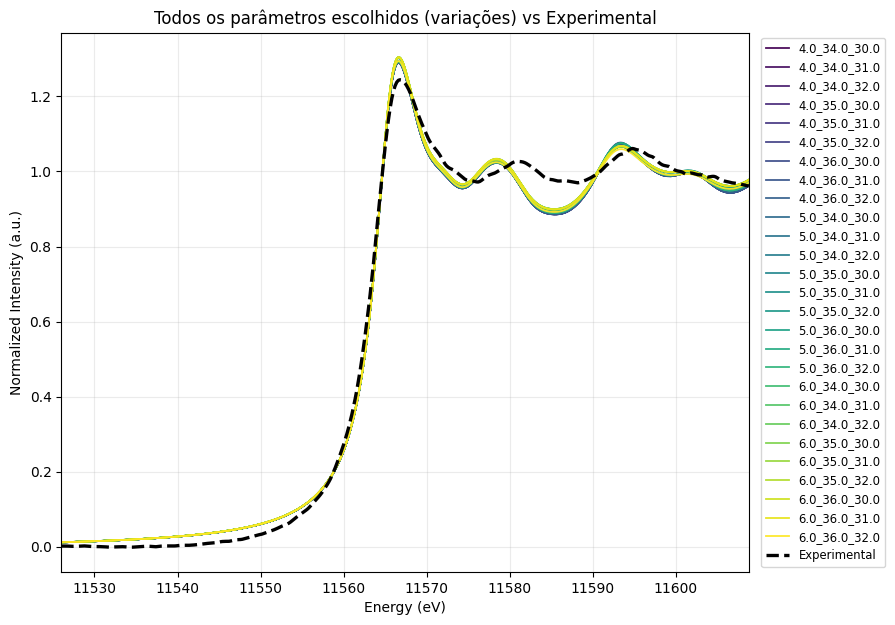

Salvo: ./param_plots/todos_parametros_vs_exp.png
Melhor curva encontrada: {'file': 'fdmnes-restart.out_Gm6.0_34.0_32.0_conv.txt', 'Gm': 6.0, 'Ecent': 34.0, 'Elarge': 32.0, 'best_shift_eV': 1.4700000000000002, 'rmse': 0.03088663207544672}


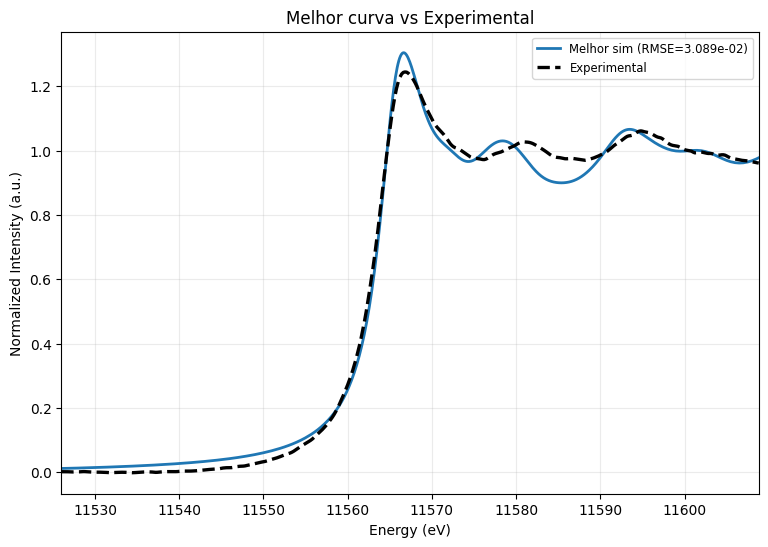

Salvo: ./param_plots/melhor_curva_vs_exp.png
Resumo salvo em: ./param_plots/parametros_escolhidos_summary.csv


In [5]:
import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# -------- CONFIG --------
SELECTED_DIR = './_parametros_escolhidos'   # pasta com os 27 arquivos
#EXP_FILE = './_experimental/XANES_Pt_Foil(MoS2)_Exp.txt'
EXP_FILE ='./_experimental/XANES_Pt_MoS2(160))_Exp.txt'
PATTERN = '*_conv.txt'
OPTIMIZE_SHIFT = True
SHIFT_SEARCH = np.linspace(-2.0, 2.0, 401)
OUT_DIR = './param_plots/'
SUMMARY_CSV = 'parametros_escolhidos_summary.csv'
os.makedirs(OUT_DIR, exist_ok=True)
# ------------------------

# ------------------ NORMALIZAÇÃO XANES ------------------
def find_E0(energies, absorption):
    dydx = np.diff(absorption) / np.diff(energies)
    x_new = energies[:-1]
    dydx2 = np.diff(dydx) / np.diff(x_new)
    x_new2 = x_new[:-1]
    
    range_search_E0_end = int(len(energies) / 2)
    deriv_max = 0
    point_max = 0
    
    for point in range(range_search_E0_end):
        if dydx[point] > deriv_max and dydx2[point] > 0:
            deriv_max = dydx[point]
            point_max = point
    
    return energies[point_max], absorption[point_max]

def fit_pre_edge(energies, absorption, start_index, end_index):
    background_x = energies[start_index:end_index]
    background_y = absorption[start_index:end_index]
    resultado_fit = linregress(background_x, background_y)
    return resultado_fit.intercept + resultado_fit.slope * energies

def XANES_normalization(energies, absorption):
    E0x, E0y = find_E0(energies, absorption)
    E0x_index = np.where(energies == E0x)[0][0]
    
    start_pre_edge_x_index = max(0, E0x_index // 15)
    end_pre_edge_x_index = max(1, E0x_index // 3)
    
    linear_fit_pre_edge = fit_pre_edge(energies, absorption, start_pre_edge_x_index, end_pre_edge_x_index)
    pre_edge_normalized_spectra = (absorption - linear_fit_pre_edge) / E0y
    
    np_start = E0x_index
    np_end = len(pre_edge_normalized_spectra)
    slope_min = float('inf')
    npt_min = np_start
    
    for npt in range(np_start, np_end - 5):
        data_x = energies[npt:np_end]
        data_y = pre_edge_normalized_spectra[npt:np_end]
        resultado_fit = linregress(data_x, data_y)
        if abs(resultado_fit.slope) < abs(slope_min):
            slope_min = resultado_fit.slope
            npt_min = npt
    
    data_x = energies[npt_min:np_end]
    data_y = pre_edge_normalized_spectra[npt_min:np_end]
    resultado_fit_final = linregress(data_x, data_y)
    predicted_faixa_final = resultado_fit_final.intercept + resultado_fit_final.slope * energies
    
    return energies, pre_edge_normalized_spectra / predicted_faixa_final
# ---------------------------------------------------------

def robust_read_twocol(path):
    try:
        df = pd.read_csv(path, sep=r'\s+', header=None, comment='#', engine='python')
    except Exception:
        data = np.genfromtxt(path, comments='#', invalid_raise=False)
        if data.ndim != 2 or data.shape[1] < 2:
            raise ValueError(f"Não consegui ler {path} como duas colunas.")
        return data[:,0].astype(float), data[:,1].astype(float)
    if df.shape[1] < 2:
        raise ValueError(f"Arquivo {path} tem menos de 2 colunas.")
    df = df.iloc[:, :2].apply(pd.to_numeric, errors='coerce').dropna()
    return df.iloc[:,0].values.astype(float), df.iloc[:,1].values.astype(float)

def rmse_between(exp_e, exp_i, sim_e, sim_i):
    sim_interp = np.interp(exp_e, sim_e, sim_i)
    return np.sqrt(np.mean((exp_i - sim_interp)**2))

def numbers_from_filename(fname):
    base = os.path.basename(fname)
    nums = re.findall(r'([0-9]+(?:\.[0-9]+)?)', base)
    return [float(x) for x in nums]

def extract_triplet(fname):
    nums = numbers_from_filename(fname)
    if len(nums) >= 3:
        return (nums[0], nums[1], nums[2])
    nums = nums + [None]*3
    return (nums[0], nums[1], nums[2])

# ---- load experimental ----
print("Carregando experimental:", EXP_FILE)
exp_e_raw, exp_i_raw = robust_read_twocol(EXP_FILE)
exp_e, exp_i = XANES_normalization(exp_e_raw, exp_i_raw)
print(f"Experimental: {len(exp_e)} pontos, Energia [{exp_e.min():.1f}, {exp_e.max():.1f}] eV")

# ---- list files ----
files = sorted(glob.glob(os.path.join(SELECTED_DIR, PATTERN)))
if len(files) == 0:
    raise FileNotFoundError(f"Nenhum arquivo '{PATTERN}' encontrado em {SELECTED_DIR}")
print(f"Arquivos encontrados: {len(files)}")

# Build list with triplet and sort lexicographically
items = []
for f in files:
    g,e,l = extract_triplet(f)
    items.append({'path': f, 'Gm': g, 'Ecent': e, 'Elarge': l})
items = [it for it in items if any(v is not None for v in (it['Gm'], it['Ecent'], it['Elarge']))]
def sort_key(it):
    def keyval(x): return x if x is not None else 1e9
    return (keyval(it['Gm']), keyval(it['Ecent']), keyval(it['Elarge']))
items.sort(key=sort_key)

n = len(items)
cmap = plt.cm.viridis(np.linspace(0,1,n))

summary_rows = []

# ---- Plot all 27 together + experimental ----
fig, ax = plt.subplots(figsize=(11,7))
for i, it in enumerate(items):
    path = it['path']
    g,e,l = it['Gm'], it['Ecent'], it['Elarge']
    try:
        sim_e_raw, sim_i_raw = robust_read_twocol(path)
        sim_e, sim_i = XANES_normalization(sim_e_raw, sim_i_raw)
    except Exception as ex:
        print("Falha ao ler", path, ex)
        continue

    best_shift = 0.0
    if OPTIMIZE_SHIFT:
        rlist = [rmse_between(exp_e, exp_i, sim_e + s, sim_i) for s in SHIFT_SEARCH]
        idx = int(np.argmin(rlist))
        best_shift = float(SHIFT_SEARCH[idx])
        best_rmse = float(rlist[idx])
    else:
        best_rmse = rmse_between(exp_e, exp_i, sim_e, sim_i)

    gstr = f"{g:.1f}" if g is not None else "NA"
    estr = f"{e:.1f}" if e is not None else "NA"
    lstr = f"{l:.1f}" if l is not None else "NA"
    short_label = f"{gstr}_{estr}_{lstr}"

    ax.plot(sim_e + best_shift, sim_i, label=short_label, color=cmap[i], linewidth=1.3, alpha=0.95)

    summary_rows.append({
        'file': os.path.basename(path),
        'Gm': g, 'Ecent': e, 'Elarge': l,
        'best_shift_eV': best_shift, 'rmse': best_rmse
    })

ax.plot(exp_e, exp_i, label='Experimental', color='black', linewidth=2.4, linestyle='--')

ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Normalized Intensity (a.u.)")
ax.set_title("Todos os parâmetros escolhidos (variações) vs Experimental")
plt.subplots_adjust(right=0.75)
leg = ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize='small', frameon=True, ncol=1)
leg.get_frame().set_edgecolor('0.8')
ax.grid(alpha=0.25)
ax.set_xlim(exp_e.min(), exp_e.max())

out_all = os.path.join(OUT_DIR, 'todos_parametros_vs_exp.png')
plt.savefig(out_all, dpi=200, bbox_inches='tight')
plt.show()
print("Salvo:", out_all)

# ---- Melhor curva ----
df = pd.DataFrame(summary_rows)
df = df.dropna(subset=['rmse'])
if df.empty:
    raise RuntimeError("Nenhuma curva com RMSE calculado (algo falhou).")

best_row = df.loc[df['rmse'].idxmin()]
best_file = os.path.join(SELECTED_DIR, best_row['file'])
print("Melhor curva encontrada:", best_row[['file','Gm','Ecent','Elarge','best_shift_eV','rmse']].to_dict())

sim_e_b_raw, sim_i_b_raw = robust_read_twocol(best_file)
sim_e_b, sim_i_b = XANES_normalization(sim_e_b_raw, sim_i_b_raw)

figb, axb = plt.subplots(figsize=(9,6))
axb.plot(sim_e_b + float(best_row['best_shift_eV']), sim_i_b, label=f"Melhor sim (RMSE={best_row['rmse']:.3e})", linewidth=2.0, color='tab:blue')
axb.plot(exp_e, exp_i, label='Experimental', linewidth=2.4, color='black', linestyle='--')
axb.set_xlabel("Energy (eV)")
axb.set_ylabel("Normalized Intensity (a.u.)")
axb.set_title("Melhor curva vs Experimental")
axb.legend(fontsize='small')
axb.grid(alpha=0.25)
axb.set_xlim(exp_e.min(), exp_e.max())

out_best = os.path.join(OUT_DIR, 'melhor_curva_vs_exp.png')
plt.savefig(out_best, dpi=200, bbox_inches='tight')
plt.show()
print("Salvo:", out_best)

# ---- save summary CSV ----
df_sorted = df.sort_values(['rmse']).reset_index(drop=True)
df_sorted.to_csv(os.path.join(OUT_DIR, SUMMARY_CSV), index=False)
print("Resumo salvo em:", os.path.join(OUT_DIR, SUMMARY_CSV))


### Melhores parâmetros
- ECENT = 34
- ELARGE = 30
- GAMMAMAX = 6

## Novo teste: muita variação de parametros

In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt

# -------- CONFIG --------
FOLDER = "./todos_parametros"
PATTERN = "*_conv.txt"
EXP_FILE = "./_experimental/XANES_Pt_Foil(MoS2)_Exp.txt"  # ajuste se necessário
OUT_PLOT_DIR = "./param_plots/"
os.makedirs(OUT_PLOT_DIR, exist_ok=True)

# -------- Funções utilitárias --------
def robust_read_twocol(path):
    energies, intensities = [], []
    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            parts = line.split()
            try:
                x = float(parts[0].replace('D','e'))
                y = float(parts[1].replace('D','e'))
                energies.append(x)
                intensities.append(y)
            except (ValueError, IndexError):
                continue
    if len(energies) == 0:
        raise ValueError(f"Não consegui ler {path} como duas colunas numéricas.")
    return np.array(energies), np.array(intensities)

def XANES_normalization(energies, absorption):
    energies = np.asarray(energies, dtype=float)
    absorption = np.asarray(absorption, dtype=float)
    E0y = absorption.max() if absorption.max() != 0 else 1e-12
    normalized = absorption / E0y
    return energies, normalized

def parse_filename(fname):
    """
    Extrai GAMMAMAX, ECENT, ELARGE do nome do arquivo:
    fdmnes-restart.out_Gm12.0_20.0_20.0_conv.txt
    """
    base = os.path.basename(fname)
    m = re.search(r'Gm([0-9\.]+)_([0-9\.]+)_([0-9\.]+)_conv', base)
    if m:
        g, e, l = m.groups()
        return float(g), float(e), float(l)
    else:
        return None, None, None

# -------- Carregar experimental --------
exp_e, exp_i = robust_read_twocol(EXP_FILE)
exp_e, exp_i = XANES_normalization(exp_e, exp_i)

# -------- Carregar todos os arquivos --------
all_files = sorted(glob.glob(os.path.join(FOLDER, PATTERN)))
records = []
for f in all_files:
    g, e, l = parse_filename(f)
    if None in (g,e,l):
        print("Ignorando arquivo não reconhecido:", f)
        continue
    fe, fi = robust_read_twocol(f)
    fe, fi = XANES_normalization(fe, fi)
    records.append({'file': f, 'GAMMAMAX': g, 'ECENT': e, 'ELARGE': l, 'E': fe, 'I': fi})

# -------- Criar gráficos --------
PARAMS = ['GAMMAMAX', 'ECENT', 'ELARGE']

for param in PARAMS:
    other_params = [p for p in PARAMS if p != param]
    # valores médios para os parâmetros fixos
    fixed_vals = {p: np.mean([r[p] for r in records]) for p in other_params}

    subset = [r for r in records if 
              np.isclose(r[other_params[0]], fixed_vals[other_params[0]]) and 
              np.isclose(r[other_params[1]], fixed_vals[other_params[1]])]

    if not subset:
        print(f"Nenhum arquivo encontrado para {param} fixando os outros parâmetros.")
        continue

    subset.sort(key=lambda x: x[param])
    n = len(subset)
    cmap = plt.cm.viridis(np.linspace(0,1,n))

    fig, ax = plt.subplots(figsize=(10,6))
    for i, r in enumerate(subset):
        ax.plot(r['E'], r['I'], color=cmap[i], label=f"{param}={r[param]:.2f}", linewidth=1.6)
    ax.plot(exp_e, exp_i, color='black', linestyle='--', linewidth=2, label='Experimental')
    ax.set_xlabel("Energy (eV)")
    ax.set_ylabel("Normalized Intensity (a.u.)")
    ax.set_title(f"Variação de {param} (outros fixos na média)")
    plt.subplots_adjust(right=0.75)
    leg = ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize='small', frameon=True)
    leg.get_frame().set_edgecolor('0.8')
    leg.get_frame().set_alpha(0.95)
    ax.grid(alpha=0.3)
    ax.set_xlim(exp_e.min(), exp_e.max())

    outpng = os.path.join(OUT_PLOT_DIR, f"{param}_variation.png")
    plt.savefig(outpng, dpi=200, bbox_inches='tight')
    plt.show()
    print("Salvo:", outpng)


Ignorando arquivo não reconhecido: ./todos_parametros\fdmnes-restart.out_Gm10_conv.txt
Ignorando arquivo não reconhecido: ./todos_parametros\fdmnes-restart.out_Gm11_conv.txt
Ignorando arquivo não reconhecido: ./todos_parametros\fdmnes-restart.out_Gm12_conv.txt
Ignorando arquivo não reconhecido: ./todos_parametros\fdmnes-restart.out_Gm13_conv.txt
Ignorando arquivo não reconhecido: ./todos_parametros\fdmnes-restart.out_Gm14_conv.txt
Ignorando arquivo não reconhecido: ./todos_parametros\fdmnes-restart.out_Gm15_conv.txt
Ignorando arquivo não reconhecido: ./todos_parametros\fdmnes-restart.out_Gm16_conv.txt
Ignorando arquivo não reconhecido: ./todos_parametros\fdmnes-restart.out_Gm17_conv.txt
Ignorando arquivo não reconhecido: ./todos_parametros\fdmnes-restart.out_Gm18_conv.txt
Ignorando arquivo não reconhecido: ./todos_parametros\fdmnes-restart.out_Gm19_conv.txt
Ignorando arquivo não reconhecido: ./todos_parametros\fdmnes-restart.out_Gm1_conv.txt
Ignorando arquivo não reconhecido: ./todos_p

C:\Users\carlos23036\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\carlos23036\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
